https://www.kaggle.com/c/avazu-ctr-prediction/overview


<b>Input Data</b>
* train.csv     ≈40.4M
* test.csv      ≈4.58M

<b>Output(Expected Value)</b>
* id
* probability of click

<b>Features</b>
* id: ad identifier
* click: 0/1 for non-click/click
* hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* C1 -- anonymized categorical variable
* banner_pos
* site_id
* site_domain
* site_category
* app_id
* app_domain
* app_category
* device_id
* device_ip
* device_model
* device_type
* device_conn_type
* C14-C21 -- anonymized categorical variablesid: ad identifier

<h1>Data前処理</h1>



In [1]:
import numpy as np
import matplotlib 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import Series,DataFrame
%matplotlib inline
matplotlib.style.use('ggplot')
import sklearn

from datetime import datetime
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
print(np.version.full_version)
print(matplotlib.__version__)
print(pd.__version__)
print(sklearn.__version__)

2019/05/01 23:44:54
1.16.2
3.0.3
0.24.2
0.20.3


In [2]:
features_mask_org =  ['id', 'click', 'hour', 'C1','banner_pos', 'site_id', 'site_domain', 'site_category', 
                      'app_id','app_domain', 'app_category', 
                      'device_id','device_ip', 'device_model', 'device_type', 'device_conn_type', 
                      'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [3]:
## data reading
date_parser = lambda x: pd.datetime.strptime(x, '%y%m%d%H')

In [4]:
import random
n = 100  # every 100th line = 1% of the lines

def load_train_data():
    train_df = pd.read_csv('./avazu-ctr-prediction/train.csv',
                           skiprows=lambda i: i % n != 0,
                           dtype={'id':str},
                           parse_dates=['hour'],
                           date_parser=date_parser)
    return train_df


In [5]:
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
train_df = load_train_data()
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

2019/05/01 23:44:54
2019/05/01 23:45:30


In [6]:
train_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10015745448500295401,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79
1,10029329644865739909,1,2014-10-21,1005,1,22d080df,6eb534a7,3e814130,ecad2386,7801e8d9,...,1,2,20596,320,50,2161,0,35,-1,157
2,10045015900189972745,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,...,1,2,15006,320,50,1637,0,161,100046,91
3,100597870766280117,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,100084,79
4,10072487305193128257,0,2014-10-21,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,15707,320,50,1722,0,35,100084,79


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404289 entries, 0 to 404288
Data columns (total 24 columns):
id                  404289 non-null object
click               404289 non-null int64
hour                404289 non-null datetime64[ns]
C1                  404289 non-null int64
banner_pos          404289 non-null int64
site_id             404289 non-null object
site_domain         404289 non-null object
site_category       404289 non-null object
app_id              404289 non-null object
app_domain          404289 non-null object
app_category        404289 non-null object
device_id           404289 non-null object
device_ip           404289 non-null object
device_model        404289 non-null object
device_type         404289 non-null int64
device_conn_type    404289 non-null int64
C14                 404289 non-null int64
C15                 404289 non-null int64
C16                 404289 non-null int64
C17                 404289 non-null int64
C18                 404289 non

In [8]:
train_df.describe()

,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000,404289.000000
mean,0.169399,1004.968213,0.288840,1.015642,0.329156,18842.358862,318.885668,59.957773,2112.632322,1.432990,228.233746,53285.630242,83.377764
std,0.375104,1.096177,0.503327,0.528487,0.852673,4957.027671,21.117349,47.080305,608.944822,1.327071,352.382243,49952.450962,70.306469
min,0.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,0.000000,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,0.000000,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100050.000000,61.000000
75%,0.000000,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100088.000000,101.000000
max,1.000000,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000


In [9]:
## 1.init_dict
cols_counts = {}  
for col in features_mask_org:
    cols_counts[col] = train_df[col].value_counts()

for k, v in cols_counts.items():
    print("{} : {}".format(k, v.size))
    

id : 404289
click : 2
hour : 240
C1 : 7
banner_pos : 7
site_id : 2184
site_domain : 2167
site_category : 23
app_id : 2266
app_domain : 145
app_category : 25
device_id : 64877
device_ip : 262655
device_model : 4368
device_type : 4
device_conn_type : 4
C14 : 2079
C15 : 8
C16 : 9
C17 : 416
C18 : 4
C19 : 64
C20 : 160
C21 : 60


<b>Exploratory Data Analysis and Feature Engineering</b>

■ID　　unique

In [10]:
train_df.shape[0] == train_df['id'].unique().shape[0]

True

■click ⇒target value

0    0.830601
1    0.169399
Name: click, dtype: float64

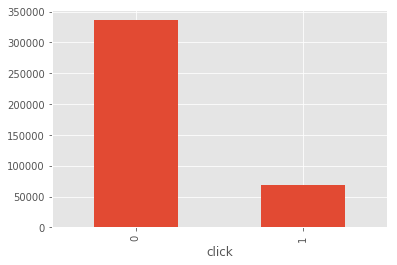

In [11]:
train_df.groupby('click').size().plot(kind='bar')
train_df['click'].value_counts() / train_df.shape[0]

■hour

* hour_day⇒feature
* day_week⇒feature


In [12]:
train_df.hour.describe()

count                  404289
unique                    240
top       2014-10-22 09:00:00
freq                     4478
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

In [13]:
def derive_time_features(df, start_hour=None, remove_original_feature=False):
    if start_hour is None:
        start_hour = df['hour'][0]
        
    df['hour_int'] = train_df['hour'].apply(lambda x: np.floor((x - start_hour) / np.timedelta64(1, 'h')).astype(np.uint16))
    df['day_week'] = train_df['hour'].apply(lambda x: x.dayofweek)
    df['hour_day'] = train_df['hour'].apply(lambda x: x.hour)
    
    if remove_original_feature:
        df.drop('hour', axis=1, inplace=True)
    
    return df, start_hour

In [14]:
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
train_df, _ = derive_time_features(train_df)
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
train_df.head()

2019/05/01 23:45:32
2019/05/01 23:45:44


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_int,day_week,hour_day
0,10015745448500295401,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,0,1,0
1,10029329644865739909,1,2014-10-21,1005,1,22d080df,6eb534a7,3e814130,ecad2386,7801e8d9,...,320,50,2161,0,35,-1,157,0,1,0
2,10045015900189972745,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,...,320,50,1637,0,161,100046,91,0,1,0
3,100597870766280117,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,100084,79,0,1,0
4,10072487305193128257,0,2014-10-21,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,320,50,1722,0,35,100084,79,0,1,0


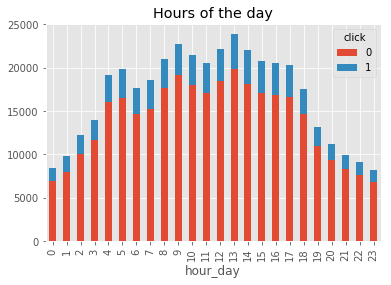

In [15]:
train_df.groupby(['hour_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Hours of the day")

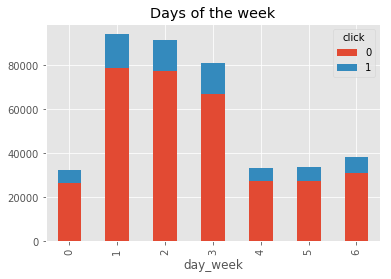

In [16]:
train_df.groupby(['day_week', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Days of the week")

■banner_pos　⇒feature

[0 1 2 5 7 4 3]


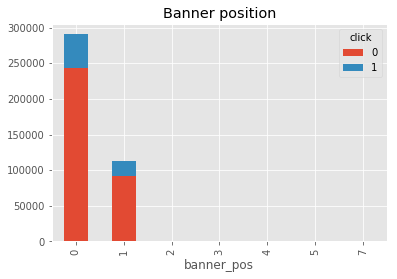

In [17]:
print(train_df['banner_pos'].unique())
train_banner_pos_group_df = train_df.groupby(['banner_pos', 'click']).size().unstack()
train_banner_pos_group_df.plot(kind='bar', stacked=True, title='Banner position')


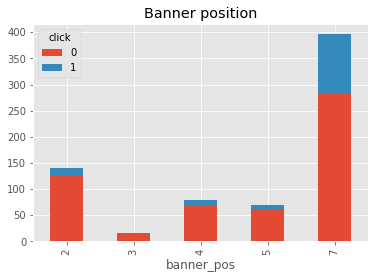

In [18]:
train_banner_pos_group_df.iloc[2:].plot(kind='bar', stacked=True, title='Banner position')

In [19]:
train_banner_pos_group_df / train_df.shape[0]

click,0,1
banner_pos,,
0,0.601362,0.117394
1,0.227882,0.051621
2,0.000309,0.000040
3,0.000037,0.000005
4,0.000166,0.000032
5,0.000148,0.000025
7,0.000698,0.000282


In [20]:
train_banner_pos_group_df.div(train_banner_pos_group_df.sum(axis=1), axis=0)

click,0,1
banner_pos,,
0,0.836671,0.163329
1,0.815310,0.184690
2,0.886525,0.113475
3,0.882353,0.117647
4,0.837500,0.162500
5,0.857143,0.142857
7,0.712121,0.287879


■Site-related features

In [21]:
site_features = ['site_id', 'site_domain', 'site_category']

train_df[site_features].describe()

,site_id,site_domain,site_category
count,404289,404289,404289
unique,2184,2167,23
top,85f751fd,c4e18dd6,50e219e0
freq,145879,151281,165316


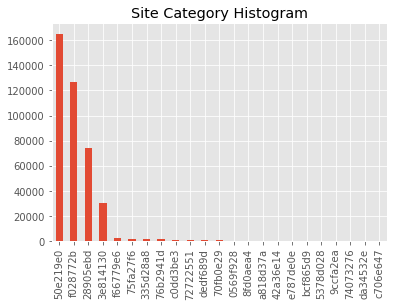

In [22]:
train_df['site_category'].value_counts().plot(kind='bar', title='Site Category Histogram')

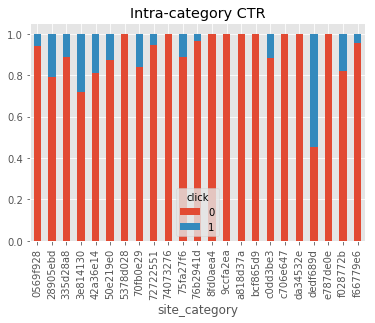

In [23]:
train_site_category_group_df = train_df.groupby(['site_category', 'click']).size().unstack()
train_site_category_group_df.div(train_site_category_group_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

■App-related features

In [24]:
app_features = ['app_id', 'app_domain', 'app_category']
train_df[app_features].describe()

,app_id,app_domain,app_category
count,404289,404289,404289
unique,2266,145,25
top,ecad2386,7801e8d9,07d7df22
freq,258410,272519,261759


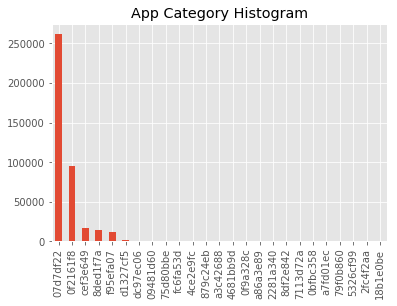

In [25]:
train_df['app_category'].value_counts().plot(kind='bar', title='App Category Histogram')

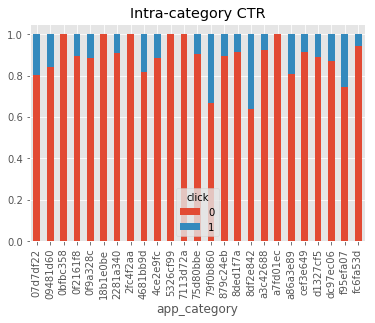

In [26]:
train_app_category_group_df = train_df.groupby(['app_category', 'click']).size().unstack()
train_app_category_group_df.div(train_app_category_group_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

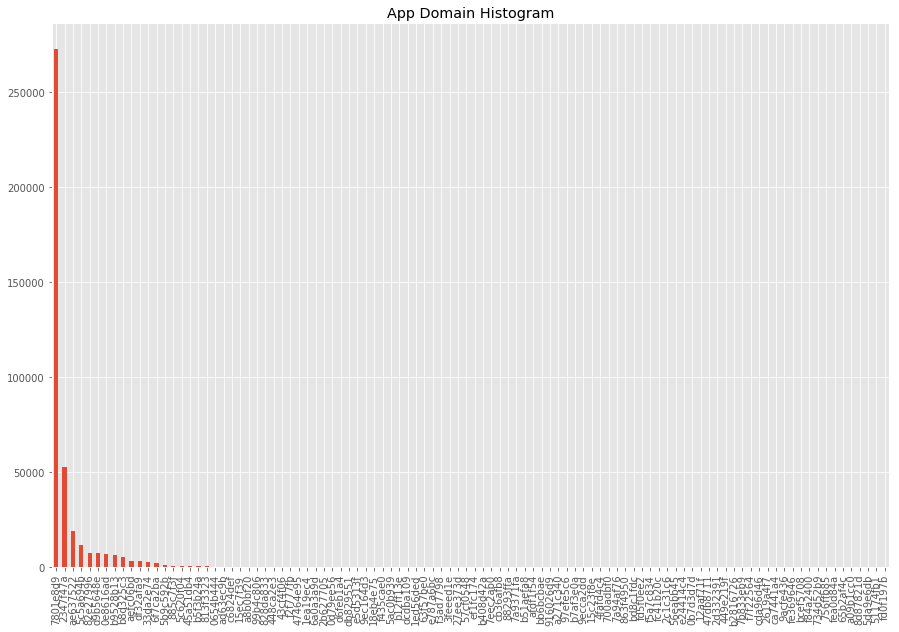

In [51]:
train_df['app_domain'].value_counts()[:100].plot(kind='bar', title='App Domain Histogram')

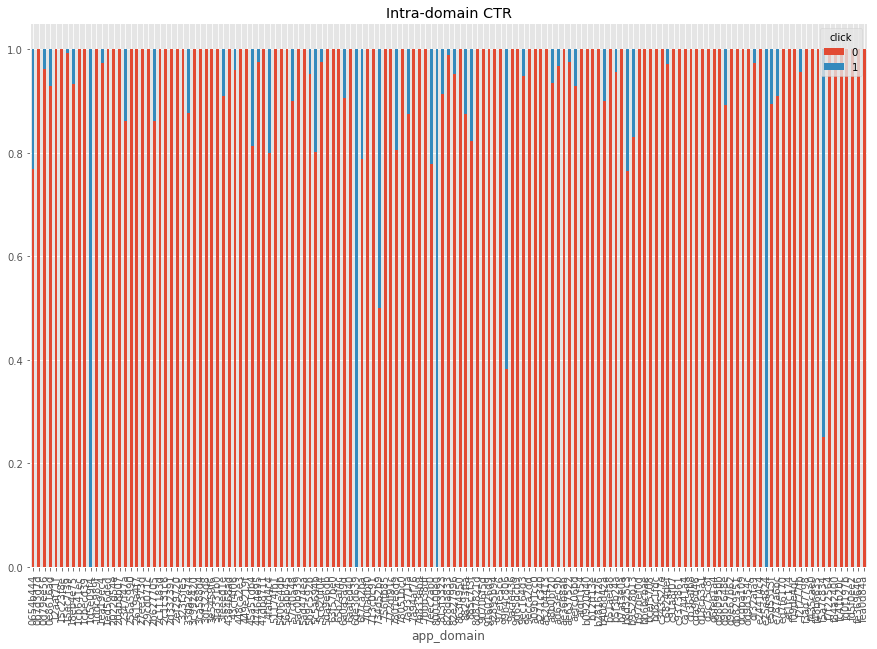

In [52]:
train_app_category_group_df = train_df.groupby(['app_domain', 'click']).size().unstack()
train_app_category_group_df.div(train_app_category_group_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-domain CTR")

■Device-related features

In [27]:
device_features = ['device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type']
train_df[device_features].astype('object').describe()

,device_id,device_ip,device_model,device_type,device_conn_type
count,404289,404289,404289,404289,404289
unique,64877,262655,4368,4,4
top,a99f214a,6b9769f2,8a4875bd,1,0
freq,333507,2141,24601,372943,349266


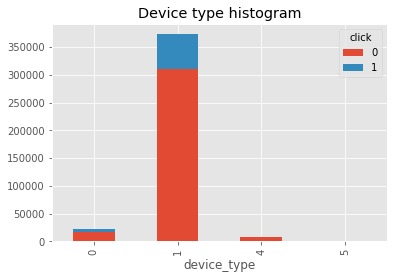

In [29]:
train_df.groupby(['device_type', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Device type histogram')

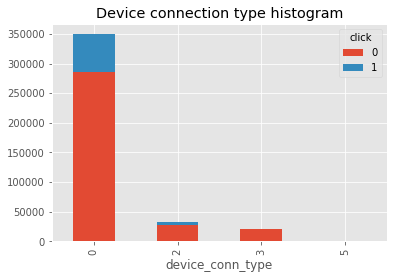

In [30]:
train_df.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Device connection type histogram')

■C1, C14-C21

In [31]:
annonym_features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
train_df[annonym_features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,404289,404289,404289,404289,404289,404289,404289,404289,404289
unique,7,2079,8,9,416,4,64,160,60
top,1005,4687,320,50,1722,0,35,-1,23
freq,371315,9533,377427,381738,45291,169532,121362,189101,89132


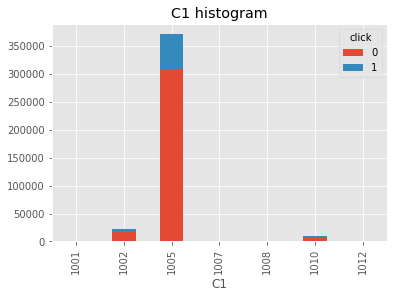

In [32]:
train_df.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')

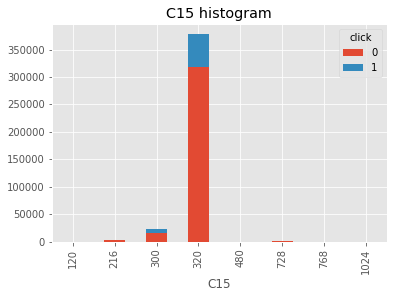

In [33]:
train_df.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 histogram')

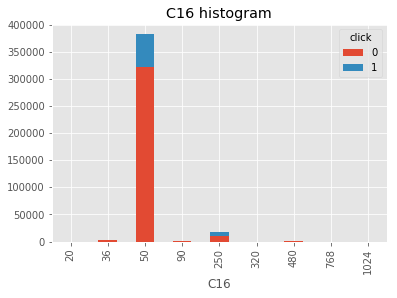

In [34]:
train_df.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 histogram')

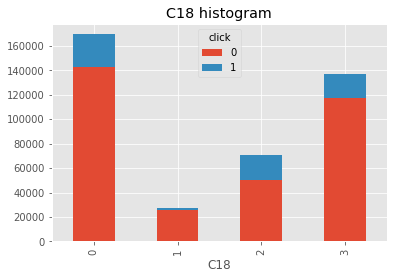

In [35]:
train_df.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 histogram')

In [36]:
train_df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_int', 'day_week',
       'hour_day'],
      dtype='object')

<b>Prediction task</b>

In [37]:
## 1.init_dict
cols_counts = {}  
for col in train_df.columns:
    cols_counts[col] = train_df[col].value_counts()

for k, v in cols_counts.items():
    print("{} : {}".format(k, v.size))

len(cols_counts)

id : 404289
click : 2
hour : 240
C1 : 7
banner_pos : 7
site_id : 2184
site_domain : 2167
site_category : 23
app_id : 2266
app_domain : 145
app_category : 25
device_id : 64877
device_ip : 262655
device_model : 4368
device_type : 4
device_conn_type : 4
C14 : 2079
C15 : 8
C16 : 9
C17 : 416
C18 : 4
C19 : 64
C20 : 160
C21 : 60
hour_int : 240
day_week : 7
hour_day : 24


27

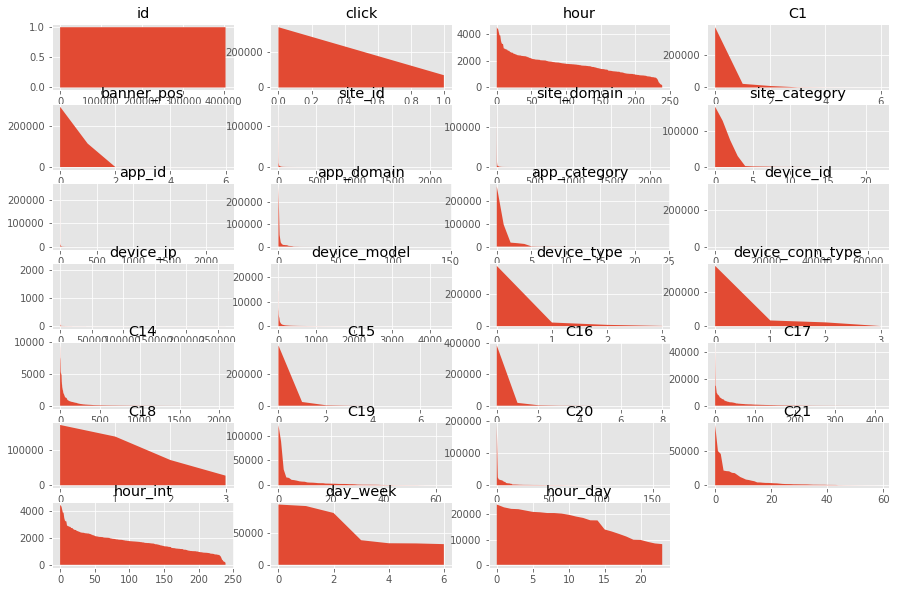

In [38]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10

fig = plt.figure(1)
for i, col in enumerate(cols_counts.keys()):
    ax = fig.add_subplot(7, 4, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    ax.set_title(col)
plt.show()

In [39]:
k = 99
col_index = {}
for col in train_df.columns:
    col_index[col] = cols_counts[col][0: k].index
col_index.pop("id", None)
col_index.pop("click", None)
col_index.pop("hour", None)
col_index.pop("hour_int", None)

col_index.pop("site_id", None)
col_index.pop("app_id", None)
col_index.pop("device_id", None)

len(col_index)

20

In [40]:
col_index.keys()

dict_keys(['C1', 'banner_pos', 'site_domain', 'site_category', 'app_domain', 'app_category', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'day_week', 'hour_day'])

In [41]:
for k, v in col_index.items():
    print("{} : {}".format(k, v.size))

C1 : 7
banner_pos : 7
site_domain : 99
site_category : 23
app_domain : 99
app_category : 25
device_ip : 99
device_model : 99
device_type : 4
device_conn_type : 4
C14 : 99
C15 : 8
C16 : 9
C17 : 99
C18 : 4
C19 : 64
C20 : 99
C21 : 60
day_week : 7
hour_day : 24


In [42]:
features_mask = list(col_index.keys())
target_mask = 'click'

In [43]:
train_sample_df = train_df[features_mask + [target_mask]].sample(frac=0.01, random_state=42)
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4043 entries, 8067 to 403067
Data columns (total 21 columns):
C1                  4043 non-null int64
banner_pos          4043 non-null int64
site_domain         4043 non-null object
site_category       4043 non-null object
app_domain          4043 non-null object
app_category        4043 non-null object
device_ip           4043 non-null object
device_model        4043 non-null object
device_type         4043 non-null int64
device_conn_type    4043 non-null int64
C14                 4043 non-null int64
C15                 4043 non-null int64
C16                 4043 non-null int64
C17                 4043 non-null int64
C18                 4043 non-null int64
C19                 4043 non-null int64
C20                 4043 non-null int64
C21                 4043 non-null int64
day_week            4043 non-null int64
hour_day            4043 non-null int64
click               4043 non-null int64
dtypes: int64(15), object(6)
memory usage:

In [44]:
train_sample_df[:50]

,C1,banner_pos,site_domain,site_category,app_domain,app_category,device_ip,device_model,device_type,device_conn_type,...,C15,C16,C17,C18,C19,C20,C21,day_week,hour_day,click
8067,1005,0,c4e18dd6,50e219e0,82e27996,0f2161f8,84fe407a,9b5ce758,1,0,...,320,50,2480,3,299,100111,61,1,4,0
368100,1005,0,c4e18dd6,50e219e0,0e8616ad,0f2161f8,d7f3760d,c4cff2ea,1,0,...,320,50,2726,3,803,-1,229,3,4,0
70497,1005,1,9164b420,28905ebd,7801e8d9,07d7df22,9501ead9,1ccc7835,1,0,...,320,50,1722,0,35,100083,79,2,11,0
226567,1005,0,f3845767,28905ebd,7801e8d9,07d7df22,5abbb838,5dee1d65,1,0,...,320,50,2299,2,1327,100084,52,6,15,0
73186,1005,0,c4e18dd6,50e219e0,5c5a694b,0f2161f8,04ea5d71,4ceb2e0b,1,0,...,320,50,423,2,39,100148,32,2,12,0
215105,1005,0,c4e18dd6,50e219e0,b9528b13,cef3e649,0d273465,ecb851b2,1,0,...,320,50,1863,3,39,-1,23,6,10,0
253209,1005,0,7687a86e,3e814130,7801e8d9,07d7df22,451ea9e0,a0f5f879,1,0,...,300,250,1994,2,39,-1,33,0,11,0
344403,1005,0,c4e18dd6,50e219e0,ae637522,cef3e649,8018f94b,e1eae715,1,2,...,320,50,2721,1,175,100191,71,2,12,0
104478,1005,1,75f9ddc3,f028772b,7801e8d9,07d7df22,fd26d385,daa861e9,1,0,...,320,50,2420,2,35,-1,69,3,5,1
163628,1005,1,7e091613,f028772b,7801e8d9,07d7df22,a503d5d8,56e6ab1d,1,0,...,320,50,1872,3,39,-1,23,4,17,0


In [45]:
train_sample_df_retest = train_sample_df[:50].copy()

for col in col_index.keys():
    train_sample_df_retest[col] = train_sample_df_retest[col].astype('object')
        # assign all the rare variables as 'other'
    train_sample_df_retest.loc[~train_sample_df_retest[col].isin(col_index[col]), col] = 'other'

train_sample_df_retest   


,C1,banner_pos,site_domain,site_category,app_domain,app_category,device_ip,device_model,device_type,device_conn_type,...,C15,C16,C17,C18,C19,C20,C21,day_week,hour_day,click
8067,1005,0,c4e18dd6,50e219e0,82e27996,0f2161f8,other,9b5ce758,1,0,...,320,50,2480,3,299,100111,61,1,4,0
368100,1005,0,c4e18dd6,50e219e0,0e8616ad,0f2161f8,other,c4cff2ea,1,0,...,320,50,2726,3,803,-1,229,3,4,0
70497,1005,1,9164b420,28905ebd,7801e8d9,07d7df22,other,1ccc7835,1,0,...,320,50,1722,0,35,100083,79,2,11,0
226567,1005,0,f3845767,28905ebd,7801e8d9,07d7df22,other,other,1,0,...,320,50,2299,2,1327,100084,52,6,15,0
73186,1005,0,c4e18dd6,50e219e0,5c5a694b,0f2161f8,other,4ceb2e0b,1,0,...,320,50,423,2,39,100148,32,2,12,0
215105,1005,0,c4e18dd6,50e219e0,b9528b13,cef3e649,other,ecb851b2,1,0,...,320,50,1863,3,39,-1,23,6,10,0
253209,1005,0,7687a86e,3e814130,7801e8d9,07d7df22,other,a0f5f879,1,0,...,300,250,1994,2,39,-1,33,0,11,0
344403,1005,0,c4e18dd6,50e219e0,ae637522,cef3e649,other,e1eae715,1,2,...,320,50,other,1,175,100191,71,2,12,0
104478,1005,1,75f9ddc3,f028772b,7801e8d9,07d7df22,other,other,1,0,...,320,50,2420,2,35,-1,69,3,5,1
163628,1005,1,7e091613,f028772b,7801e8d9,07d7df22,other,other,1,0,...,320,50,1872,3,39,-1,23,4,17,0


In [46]:
def one_hot_obj_features(df, features):
    new_df = pd.get_dummies(df, columns=features, sparse=True)
    return new_df

In [47]:
train_sample_df_retest = one_hot_obj_features(train_sample_df_retest, features_mask)
train_sample_df_retest.head()

,click,C1_1002,C1_1005,banner_pos_0,banner_pos_1,site_domain_17d996e6,site_domain_5c9ae867,site_domain_6b59f079,site_domain_75f9ddc3,site_domain_7687a86e,...,hour_day_10,hour_day_11,hour_day_12,hour_day_13,hour_day_14,hour_day_15,hour_day_16,hour_day_17,hour_day_18,hour_day_21
8067,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368100,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70497,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
226567,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
73186,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
